In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns
sns.set_context('notebook')

In [2]:
import sys
sys.path.append('../')

## define the model 

*(using model notation)*

-----------

$$ h_1 = W_1 x_0\quad\quad x_1 = \operatorname{tanh}(h_1)\quad\quad x_2 = W_2x_1$$

where
$$x_0\in\mathbb{R}^{n_0}, h_1\in\mathbb{R}^{n_1}, x_1\in\mathbb{R}^{n_1}, x_2\in\mathbb{R}^{n_2}$$

In [5]:
# dimensions
n0 = 2 # input dimension / number of input units
n1 = 3 # hidden dimension / number of hidden layer units
n2 = 1  # output dimension

# weights
W1 = 1/np.sqrt(n1)*np.random.randn(n1, n0) # input to hidden. n1 x n0 iid Guassian
W2 = 1/np.sqrt(n1)*np.random.randn(n2, n1) # hidden to output. n2 x n1 iid Gaussian

#W1 = np.array([[2], [4]]) # size 2 x 1
#W2 = np.array([[1 , 0]]) # size 1 x 2

# inputs
num_examples = 9

#x0 = np.linspace(-1, 1, num_examples)[np.newaxis, :]

#x0 = np.random.randn(n0, num_examples) # n0 x num_examples matrix

x0 = np.meshgrid(np.linspace(-1, 1, num_examples), np.linspace(-1, 1, num_examples))
x0 = np.stack((x0[0].flatten(), x0[1].flatten()), axis=0)
num_examples = num_examples**2

In [6]:
# forward pass on the model
h1 = np.dot( W1, x0 )
x1 = np.tanh( h1 )
x2 = np.dot( W2, x1 )

## define inverse functions

*(using generic notation)*

------------

`x = linear_inv(y, x_0, A)` implements

$$x = x_0 - A^\dagger A x_0 + A^\dagger y$$

In [7]:
def linear_inv(y, x_0, A):
  Apinv = np.linalg.pinv(A)
  return x_0 - np.dot(Apinv, np.dot(A, x_0)) + np.dot(Apinv, y)

---------------
`x = linear_rinv(y, x_0, A, gamma)` implements

$$ x = (A^\top A + \gamma I)^{-1}(A^\top y + \gamma x_0) $$

In [8]:
def linear_rinv(y, x_0, A, gamma=1e-2):
  return np.dot( np.linalg.inv(np.dot(A.T, A) + gamma*np.eye(x_0.shape[0])), np.dot(A.T, y) + gamma*x_0 )

--------------
`x = tanh_inv(y, x_0, th)` implements (note, `x_0` is not used)

$$ x = tanh^{-1}(y) = \frac 1 2 \log (\frac{1+y}{1-y})$$

for $y\in[-1+\epsilon, 1-\epsilon]$. Here, `th`=$\epsilon$. 

For $y<-1+\epsilon$, the function returns $x = tanh^{-1}(-1+\epsilon)$

For $y>1-\epsilon$, the function returns $x = tanh^{-1}(1-\epsilon)$

In [9]:
def tanh_inv(y, x_0=None, th=1e-2):
  y = np.piecewise(y, [y <= (-1+th), y > (-1+th), y >= (1-th)], [-1+th, lambda y_: y_, 1-th])
  return 0.5*np.log((1. + y)/(1. - y))

---------------
`x = tanh_rinv(y, x_0, gamma)` implements the solution to

$$
\begin{align}
  x & = \underset{\tilde{x}}{argmin} \| tanh(\tilde{x}) - y \|_2^2 + \gamma \| \tilde{x} - x_0 \|_2^2
\end{align}
$$

using scipy's `fmin` function. 

In [10]:
def tanh_rinv(y, x_0, gamma=1e-2):
  from scipy.optimize import fmin
  def cost(x_tilde, y, x_0):
    return np.sum((np.tanh(x_tilde) - y)**2 + gamma*(x_tilde - x_0)**2, axis=0)
  x = tanh_inv(y, x_0, th=1e-10)
  for i in range(y.shape[1]):
    x[:, i] = fmin(cost, x[:, i], args=(y[:, i], x_0[:, 1]), xtol=1e-5, ftol=1e-5, maxiter=50, disp=0)
  return x

## train model
------------

In [11]:
W1_est = 1/np.sqrt(n1)*np.random.randn(n1, n0) # initialization of W1
#W1_est = np.array([[-3], [1]])

In [12]:
# forward pass
h1_est = np.dot( W1_est, x0 )
x1_est = np.tanh( h1_est )
x2_est = np.dot( W2, x1_est )
loss_old = 0.5*np.mean((x2_est - x2)**2)
print "loss_old", loss_old

loss_old 0.0267935846757


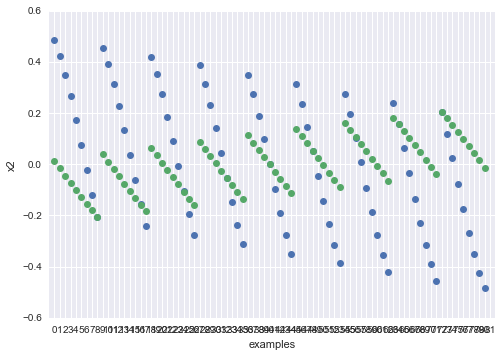

data=blue, estimates=green


In [13]:
f = plt.plot(x2.T,'o')[0]
plt.plot(x2_est.T,'o')
plt.xlim([-1, num_examples+1])
f.axes.xaxis.set_ticks(np.arange(0, num_examples+1))
plt.xlabel('examples')
plt.ylabel('x2')
plt.show()
print "data=blue, estimates=green"

In [14]:
# backward pass.
x1_target = linear_inv( x2, x1_est, W2 )
h1_target = tanh_inv( x1_target, h1_est, 1e-12 )
W1_est = linear_inv( h1_target.T, W1_est.T, x0.T ).T # note, we have to transpose all the inputs, then transpose the output of linear_inv()

In [15]:
# new forward pass
h1_est_new = np.dot( W1_est, x0 )
x1_est_new = np.tanh( h1_est_new )
x2_est_new = np.dot( W2, x1_est_new )
loss_new = 0.5*np.mean((x2_est_new - x2)**2)

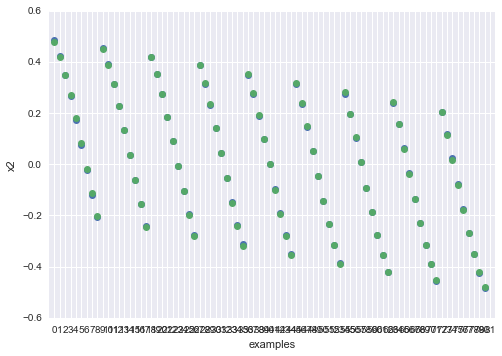

data=blue, estimates=green


In [16]:
f = plt.plot(x2.T,'o')[0]
plt.plot(x2_est_new.T,'o')
plt.xlim([-1, num_examples+1])
f.axes.xaxis.set_ticks(np.arange(0, num_examples+1))
plt.xlabel('examples')
plt.ylabel('x2')
plt.show()
print "data=blue, estimates=green"

In [17]:
print "loss_old", loss_old
print "loss_new", loss_new

loss_old 0.0267935846757
loss_new 4.36302023855e-06


### visualize learning

In [18]:
cmap = sns.color_palette("RdBu", num_examples)
sort_inds = np.argsort(x2[0])

In [19]:
cmap_sorted = [cmap[i] for i in np.argsort(sort_inds)]

In [20]:
def axify(ax, lims=None):
  ax.axis('square')
  if not lims:
    lims = ax.get_xlim() + ax.get_ylim()
    lims = min(lims), max(lims)
  ax.set_xlim(lims)
  ax.set_ylim(lims)

  ax.xaxis.set_ticks(np.arange(np.floor(lims[0]), np.ceil(lims[1]), 1))
  ax.yaxis.set_ticks(np.arange(np.floor(lims[0]), np.ceil(lims[1]), 1))
  
  ax.hlines([0], *ax.get_xlim(), linewidth=0.75, alpha=0.5)
  ax.vlines([0], *ax.get_ylim(), linewidth=0.75, alpha=0.5)


In [121]:
def add_scatterplot(fig, nrows, ncols, subplot, data, args):
  
  if data.shape[0]==1:
    ax = fig.add_subplot(nrows, ncols, subplot)
    #ax.scatter(data[0,:], np.zeros_like(data), **args)
    ax.scatter(data[0,:], 0.2*(np.random.rand(1, data.shape[1])-0.5), **args)
    axify(ax)
  elif data.shape[0]==2:
    ax = fig.add_subplot(nrows, ncols, subplot)
    ax.scatter(data[0,:], data[1,:], **args)
    axify(ax)
  elif data.shape[0]>2:
    ax = fig.add_subplot(nrows, ncols, subplot, projection='3d')
    ax.scatter(data[0,:], data[1,:], data[2,:], **args)

  return ax

In [122]:
def append_scatterplot(ax, data, args):

  if data.shape[0]==1:
    ax.scatter(data[0,:], np.zeros_like(data), **args)
  elif data.shape[0]==2:
    ax.scatter(data[0,:], data[1,:], **args)
  elif data.shape[0]>2:
    ax.scatter(data[0,:], data[1,:], data[2,:], **args)

  return ax

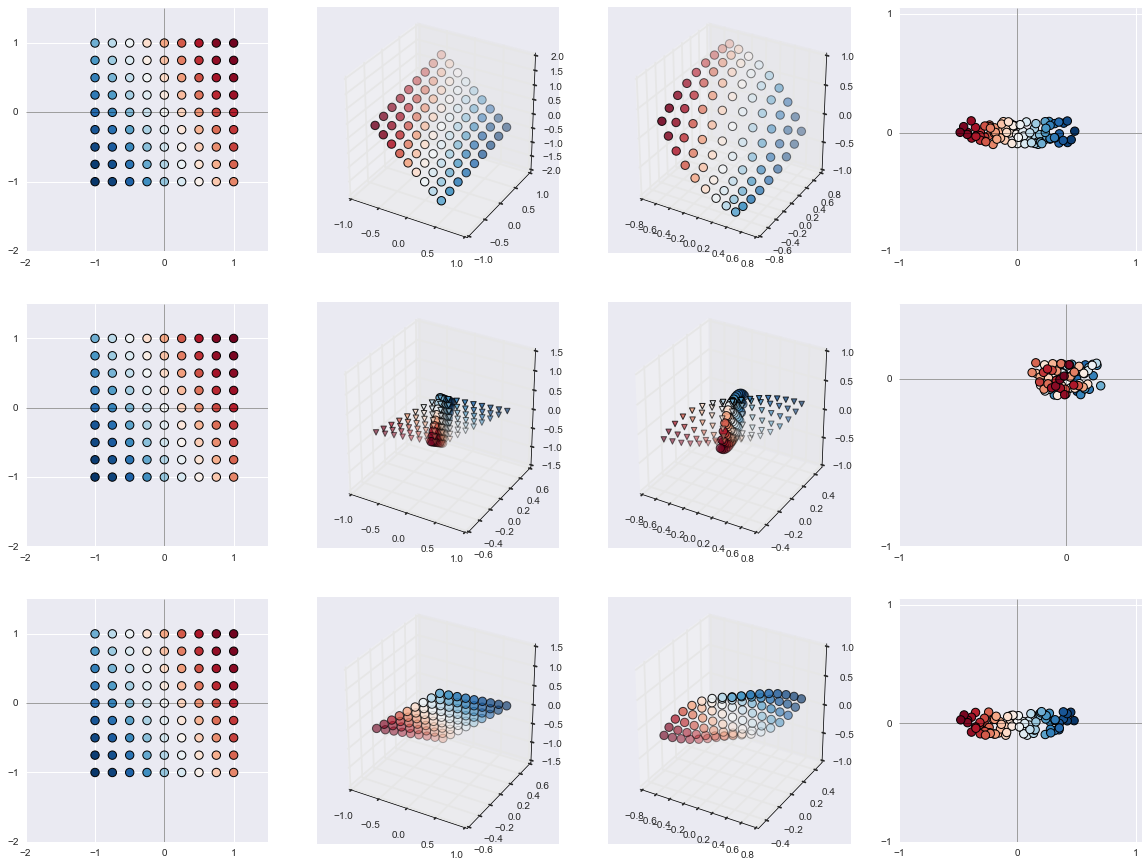

In [123]:
rows = 3
cols = 4
mult = 5

fig = plt.figure(figsize=(mult*cols, mult*rows))

args = {}
args['c'] = cmap_sorted
args['s'] = 70
args['linewidth'] = 1

args2 = {}
args2['c'] = cmap_sorted
args2['s'] = 30
args2['linewidth'] = 2

args3 = {}
args3['c'] = cmap_sorted
args3['s'] = 30
args3['linewidth'] = 1
args3['marker'] = 'v'


ax = []

i = 0
ax.append(add_scatterplot(fig, rows, cols, i+1, x0, args))

i=1
ax.append(add_scatterplot(fig, rows, cols, i+1, h1, args))

i=2
ax.append(add_scatterplot(fig, rows, cols, i+1, x1, args))

i=3
ax.append(add_scatterplot(fig, rows, cols, i+1, x2, args))

###
i=4
ax.append(add_scatterplot(fig, rows, cols, i+1, x0, args))

i=5
ax.append(add_scatterplot(fig, rows, cols, i+1, h1_est, args))
append_scatterplot(ax[-1], h1_target, args3)

i=6
ax.append(add_scatterplot(fig, rows, cols, i+1, x1_est, args))
append_scatterplot(ax[-1], x1_target, args3)

i=7
ax.append(add_scatterplot(fig, rows, cols, i+1, x2_est, args))

###
i=8
ax.append(add_scatterplot(fig, rows, cols, i+1, x0, args))

i=9
ax.append(add_scatterplot(fig, rows, cols, i+1, h1_est_new, args))

i=10
ax.append(add_scatterplot(fig, rows, cols, i+1, x1_est_new, args))

i=11
ax.append(add_scatterplot(fig, rows, cols, i+1, x2_est_new, args))


Toy example.

Input dimension: 1. One-dimensional inputs shown in column 1 plotted vertically.

Hidden dimension: 2. $h_1$ and $x_1$ plotted in column 2 and 3.

Output dimension: 1. One-dimensional outputs shown in column 4 plotted horizontally.

First row. Model that generates $x_2$ outputs, where $W_1=[2\;\; 4]^\top$ and $W_2=[1\;\; 0]$:

$$x_0 \quad\rightarrow\quad h_1 = W_1x_0 \quad\rightarrow\quad x_1=tanh(h_1) \quad\rightarrow\quad x_2=W_2x_1$$

Second row (circles). Everything is known except $W_1$. We start with an initial random estimate of $W_1$, which we specify as, say, $\tilde{W}_1 = [-3\;\; 1]$

$$x_0 \quad\rightarrow\quad \tilde{h}_1 = \tilde{W}_1x_0 \quad\rightarrow\quad \tilde{x}_1=tanh(\tilde{h}_1) \quad\rightarrow\quad \tilde{x}_2=W_2\tilde{x}_1$$

Note that the final output $\tilde{x}_2\neq x_2$. In particular, the color of the dots are in the wrong orientation.

Second row (triangles). We then invert the true output $x_2$ backward to create targets. E.g. if we look at row 2, column 3. The red target is in the preimage of the red $x_2$ (row 1, column 4) through the $W_2=[1\;\;0]$ linear function. We choose the red target $\hat{x}_2$ that is in the preimage, and is closest to the current $\tilde{x}_2$. We then invert the targets through $\operatorname{tanh}^{-1}$ again to get the triangles in row 2 column 2. We use these targets to get a new $W_1$. 

Third row (circles). Using the newly trained $W_1$, we propagate forward and find that the new $x_2$ matches the real $x_2$.

-----------

Note: This example is a bit trivial. What is a good minimally nontrivial toy example? One triviality of the above example: The target propagation scheme of choosing an element in the preimage closest to the current activation *does not* help in training. We could have assigned $x_1$ targets (row 2, col 3) by $\hat{x}_1 = W_2^\dagger x_2$ instead of offsetting each point. What is a good example where our target assignment approach is necessary for training?

In [22]:
def plot3d_lines(ax):
  args = {'linewidth':0.5, 'alpha':0.5}
  xlim = ax.get_xlim()
  ylim = ax.get_ylim()
  zlim = ax.get_zlim()
  for i in range(3):
    ax.plot([0,0], [0,0], [-zlim, zlim], 'k', **args)
    ax.plot([0,0], [-ylim, ylim], [0,0], 'k', **args)
    ax.plot([-xlim, xlim], [0,0], [0,0], 'k', **args)
